# Piezómetros Mar Menor

In [2]:
import getpass
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import psycopg2
import pandas as pd
import pandas.io.sql as psql
%matplotlib widget

In [3]:
import sys
sys.path.append(r'C:\Users\solis\Documents\DEV\python3\common')
import plot_with_mpl as p

## Reload module plot_with_mpl

In [5]:
from importlib import reload # python 2.7 does not require this
import plot_with_mpl
reload(plot_with_mpl)
import plot_with_mpl as p

## Figure parameters

In [6]:
x_cm = 11
x_in, y_in = p.fig_size_cm_2_in(x_cm)
print(x_in, y_in)

4.330708661417323 3.248031496062992


In [8]:
mpl.rcdefaults()
plt.rc('figure', figsize=(x_in, y_in), dpi=80)
plt.rc('font', size=8)
plt.rc('axes', labelsize=8, titlesize= 9, grid=True)
plt.rc('axes.spines', right=False, top=False)
plt.rc('xtick', direction='out', top=False)
plt.rc('ytick', direction='out', right=False)
plt.rc('lines', linewidth=0.8, linestyle='-', marker='.', markersize=4)
plt.rc('legend', fontsize=8, framealpha=0.5, loc='best')

plt.subplots_adjust(hspace=0.1, bottom=0.16, top=0.87)
plt.close()

## Functions

## Database

In [9]:
db = getpass.getpass('DB: ')
user = getpass.getpass('User: ')
passw = getpass.getpass('Password: ')
con = psycopg2.connect(database=db, user=user, password=passw)
cur = con.cursor()

DB:  ···
User:  ········
Password:  ··


## Data

### Desembocadura Albujón

In [10]:
# desembocadura albujón
select = \
"""
select t.fecha::date fecha, (avg(t.v)) q
from saih.tsh t 
where id = '06a18' and t.var='q01'
group by t.fecha::date
order by t.fecha::date
"""
df_alb18 = psql.read_sql(select, con)

In [62]:
df_alb18.head()

,fecha,q
0,2021-01-12,0.183242
1,2021-01-13,0.184608
2,2021-01-14,0.177271
3,2021-01-15,0.174525
4,2021-01-16,0.172125


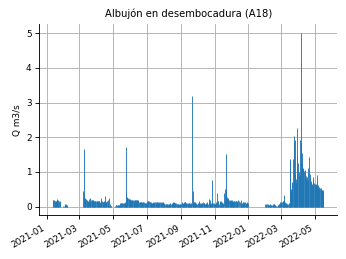

In [11]:
p.stem_1(df_alb18['fecha'], df_alb18['q'], 'Albujón en desembocadura (A18)', 'Q m3/s')

### Piezómetros

In [14]:
#### Pluviómetros más próximos a cada piezómetro
select = \
"""
with plvs as (
select t1.id, t1.name, t1.geom
from saih.puntos t1 
	join saih.tsd t2 using(id)
where var = 'p01'
group by t1.id, t1.name
),
pzs as (
select t1.id, t1.name, t1.geom
from saih.puntos t1 
	join saih.tsd t2 using(id)
where var = 'e10'
group by t1.id, t1.name
)
select t1.id piez, 
	split_part(min(concat(st_distance(t1.geom, t2.geom), ' - ', t2.id)), ' - ', 2) pluvio, 
	split_part(min(concat(st_distance(t1.geom, t2.geom), ' - ', t2.id)), ' - ', 1) distance
from pzs t1, plvs t2 
group by t1.id
order by t1.id 
"""
df_pz_plv = psql.read_sql(select, con)

In [15]:
df_pz_plv.head()

,piez,pluvio,distance
0,06z01,06a01,15678.747526508614
1,06z02,06a01,14901.546362710147
2,06z03,06p02,16496.78683865437
3,06z05,06a04,598007.1926398545
4,06z06,06p02,12304.178152156283


In [16]:
piez1 = '06z01'
       
# datos piezómetro
select = \
"""
select t.id, t.fecha , t.v 
from saih.tsd t 
where t.id = %s and t.var = 'e10' 
order by t.fecha
"""
df_cnp = psql.read_sql(select, con, params=(piez1,))
if len(df_cnp) == 0:
    raise ValueError(f'el piezómetro {piez1} no tiene datos')

# pluviómetro relacionado con el piezómetro
pluvio1 = 'Not found'
for row in zip(df_pz_plv['piez'],df_pz_plv['pluvio']):
    if row[0] == piez1:
        pluvio1 = row[1]
        exit

# datos pluviométricos
select = \
"""
select t.id, t.fecha , t.v 
from saih.tsd t 
where t.id = %s and t.var = 'p01' and t.v>0 and t.fecha >= '2019-10-01'
order by fecha
"""
df_plv = psql.read_sql(select, con, params=(pluvio1,))
if len(df_plv) == 0:
    raise ValueError(f'el pluviómetro {pluvio1} no tiene datos')
    

In [128]:
df_plv.head()

,id,fecha,v
0,06a01,2019-10-14,4.3
1,06a01,2019-10-21,19.0
2,06a01,2019-10-22,13.0
3,06a01,2019-11-09,0.1
4,06a01,2019-11-17,7.9


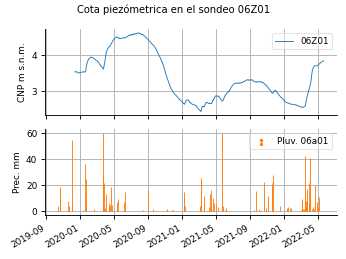

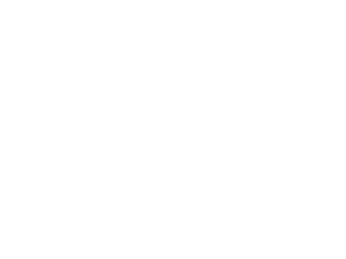

In [17]:
p.subplot_nv([df_cnp['fecha'], df_plv['fecha']],
             [df_cnp['v'], df_plv['v']],
             [f'{piez1.upper()}', f'Pluv. {pluvio1}'],
             f'Cota piezómetrica en el sondeo {piez1.upper()}', 
             ['CNP m s.n.m.', 'Prec. mm'])